In [140]:
import pandas as pd

# Methods

## Defining U.S. Production Boundaries

We define the production boundary for the timber asset account along two dimensions: tree species and spatial extent. The spatial extent is inferred from regions where timber markets are currently active. These regions indicate that buyers (forestry and logging operations) and sellers (timber owners) value the trees as assests when making management decisions. There are four primary U.S. timber markets; the south (11 states), northeast (mostly Maine), the lake states (Michigan, Minnesota, and Wisconsin), and the pacific northwest (Washington, Oregon, and Northern California). Each of these regions has specialized their timber markets to utilize their distinct tree species distribution, topology, and climatic conditions.

### The Southern United States
    
The Southern U.S. market is dominated by yellow pine species (list them) including loblolly pine that makes up X% of total harvest. Because of the heavy concentration of yellow pine, standing timber prices are reported broadly with species distinctions falling into only two categories; pine and hardwood. Pine timber is utilized for building materials needing large sawlog size timber, and pulpwood for paper products relying on smaller trees harvested during thinning operations and residue from processing larger timber. Given these market characteristics, we stratify the standing timber biomass according to diameter size class estimated from the U.S. Forest Service's National Forest Inventory.

Timber Price data for the southern U.S. is curated by TimberMart South, a private firm providing price and market analysis across 11 states. Each state has two regions that generally divide the landscape between the coastal plain and the piedmont region. (what makes these regions different?). Similarly, the NFI estimates forest extent and condition across survey units designed to capture the climatic and topological differences betweent the coastal plain, piedmont, and Appalachian mountain range.

### The Great Lakes Region

The Great Lakes region is comprised of the northern portions of Michigan, Minnesota, and Wisconsin. This region's timber market has formed around large, slow growing hardwood tree species.

### Spatial Extent

We link price data to biomass volume using the county fips identifier. Each county belongs to a distinct survey unit and price region. 

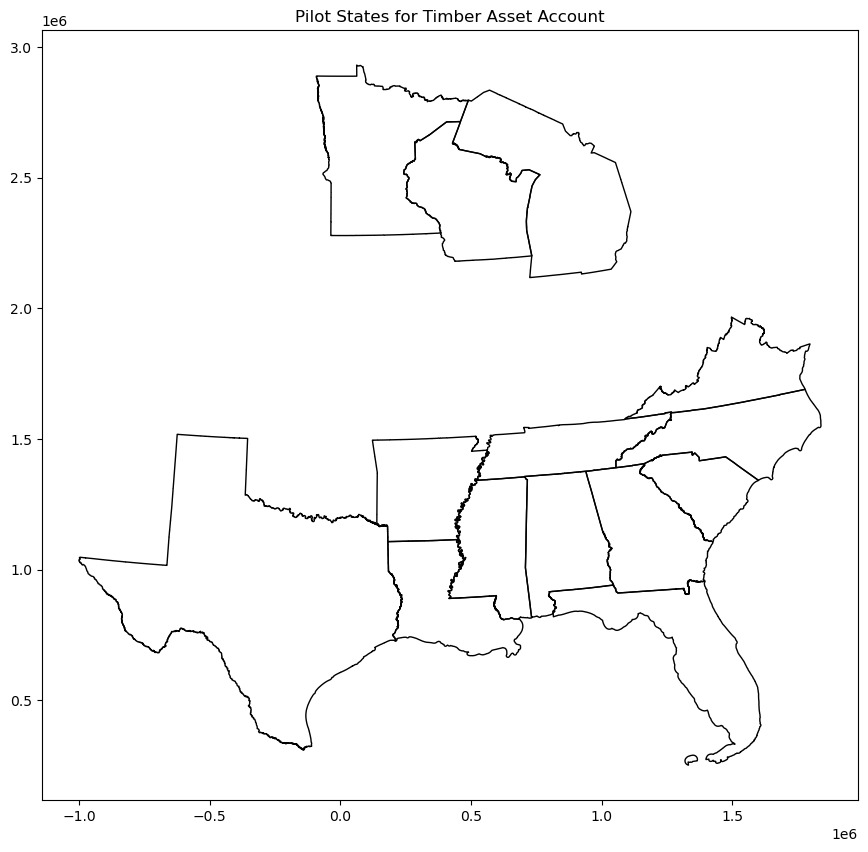

In [141]:
# draw a map of the counties with reported stumpage prices
# use cartopy to draw the map

import geopandas as gpd
import matplotlib.pyplot as plt

# define the states included in the pilots as pilotStates; use state_abbr
pilotStates = ['MI', 'MN', 'WI', 'TX', 'LA', 'MS',
                'AL', 'FL', 'GA', 'SC', 'NC', 'VA', 'TN', 'AR']


# Load the shapefiles locally
statesPath = '/Users/mihiarc/Work/spatial-boundaries/tl_2023_us_state/tl_2023_us_state.shp'
states = gpd.read_file(statesPath)

# filter the states and counties to only include the pilot states
states = states[states['STUSPS'].isin(pilotStates)]

# Change the CRS to Albers Equal Area
albers_crs = 'EPSG:5070'
states = states.to_crs(albers_crs)

# Plot the filtered states
fig, ax = plt.subplots(figsize=(15, 10))
states.plot(ax=ax, edgecolor='black', facecolor='none')

# Set plot title
plt.title('Pilot States for Timber Asset Account')

# Show the plot
plt.show()


In [142]:

# # Use GeoPandas to read the GeoJSON data
# gdf = gpd.GeoDataFrame.from_features(counties['features'])
# gdf.set_crs(epsg=4326, inplace=True)

# priceRegions = pd.read_csv('../data/priceRegions.csv')

# # filter GEOID in the geojson_counties data where priceRegion is defined
# gdf = gdf[gdf['GEOID'].isin(priceRegions['fips'])]

# # Create a new plot with Cartopy
# fig, ax = plt.subplots(figsize=(15, 10))

# # Plot the counties
# gdf.plot(ax=ax, edgecolor='black', facecolor='none',)

# # add state boundaries from geojson_states

# gdf_states = gpd.GeoDataFrame.from_features(geojson_states['features'])
# gdf_states.set_crs(epsg=5070, inplace=True)
# gdf_states.boundary.plot(ax=ax, color='purple')

# # Set plot title
# plt.title('Counties with reported Stumpage Prices')

# # Show the plot
# plt.show()

### Matching Timber Biomass Data with Market Prices

#### Stumpage vs Delivered Price

We use stumpage price because our objective is to value the timber asset prior to harvesting. Once timber is harvested the asset moves out of the timber account into the national account for forestry and logging where value is added through additional human and capital inputs. The delivered price is paid to loggers at the mill and differs from stumpage based on the cost of harvesting the trees and transporting them to the mill.

#### TimberMart South Stumpage Prices

In [ ]:
# process southern stumpage prices
pricesSouth = pd.read_csv('../data/Timber Prices/prices_south.csv')

# columns 4 through 69 are stumpage prices grouped by product type,
# state abbreviation and state region. for example, sawfl1 is sawtimber prices for
# state of Florida and Florida region 1. we can use the pandas melt function to
# convert these columns into rows

pricesSouth = pricesSouth.melt(
    id_vars=pricesSouth.columns[0:3],
    value_vars=pricesSouth.columns[3:69],
    var_name='product',
    value_name='price'
    )

# split the product column into three columns: product, stateAbbr, priceRegion
pricesSouth['stateAbbr'] = pricesSouth['product'].str[3:5].str.upper()
pricesSouth['priceRegion'] = pricesSouth['product'].str[5:].str.zfill(2)
pricesSouth['product'] = pricesSouth['product'].str[:3]

# drop product if equal to 'pre'
pricesSouth = pricesSouth[pricesSouth['product'] != 'pre']

# change 'saw' to 'Sawtimber' and 'pul' to 'Pulpwood'
pricesSouth['product'] = pricesSouth['product'].replace({'saw': 'Sawtimber',
                                                         'plp': 'Pulpwood'})

# change 'pine' and 'oak' to 'Pine' and 'Oak'
pricesSouth['type'] = pricesSouth['type'].replace({'pine': 'Pine',
                                                    'oak': 'Oak'})

# change column 'type' to 'priceSpecies'
pricesSouth.rename(columns={'type': 'priceSpecies'}, inplace=True)

# add state fips code
state_fips = {'AL': '01', 'AR': '05', 'FL': '12', 'GA': '13', 'KY': '21',
              'LA': '22', 'MS': '28', 'NC': '37', 'OK': '40', 'SC': '45',
              'TN': '47', 'TX': '48', 'VA': '51'}
pricesSouth['statecd'] = pricesSouth['stateAbbr'].map(state_fips)

# aggregate prices by year, state, priceRegion, product, priceSpecies
pricesSouth = pricesSouth.groupby(['statecd', 'stateAbbr', 'priceRegion',
                                  'priceSpecies', 'product'])['price'].mean().reset_index()

# convert price to dollars per cubic foot from dollars per ton
# 1 ton = 40 cubic feet
pricesSouth['price'] = pricesSouth['price'] / 40
pricesSouth.rename(columns={'price': 'cuftPrice',
                            'product': 'Product'}, inplace=True)

# group by priceSpecies and product to return the mean over all years
pricesSouth = pricesSouth.groupby(['statecd', 'stateAbbr', 'priceRegion',
                                  'priceSpecies', 'Product'])['cuftPrice'].mean().reset_index()

# print the first 5 rows of the pricesSouth dataframe
# print(pricesSouth.head())

## Filter species by harvest activity and market signal

A species has a market signal if individual species prices are reported

In [144]:
# load harvest species list
harvestSpecies = pd.read_csv('../data/Southern harvested tree species.csv')

# drop if ESTIMATE is 0
harvestSpecies = harvestSpecies[harvestSpecies['ESTIMATE'] != 0]

# drop if Estimate is NaN
harvestSpecies = harvestSpecies.dropna(subset=['ESTIMATE'])

# characters 7 and 8 are of GRP2 is state fip code. extract and name columm statecd
harvestSpecies['statecd'] = harvestSpecies['GRP2'].str[6:8]

# 12-14 of GRP1 is the species code. extract and name column spcd
harvestSpecies['spcd'] = harvestSpecies['GRP1'].str[11:14]

# convert spcd to int64
harvestSpecies['spcd'] = harvestSpecies['spcd'].astype('int64')

# rename ESTIMATE to volume
harvestSpecies.rename(columns={'ESTIMATE': 'volume'}, inplace=True)

# keep only the columns we need
harvestSpecies = harvestSpecies[['statecd', 'spcd']]

# sort and print the unique species
species = harvestSpecies.drop_duplicates()
species = species.sort_values('spcd')
#print(species['spcd'].unique())

# make a list of marketable species
marketSpecies = [68, 110, 111, 121, 129, 131, 132, 221, 314, 318,
                 409, 402, 403, 404, 407, 541, 544, 546, 601, 602,
                 611, 621, 651, 652, 653, 762, 802, 804, 812, 822,
                 823, 830, 832, 837, 405]

# filter the harvestSpecies to only include marketable species
harvestSpecies = harvestSpecies[harvestSpecies['spcd'].isin(marketSpecies)]
                                
# print the unique species
species = harvestSpecies.drop_duplicates()
species = species.sort_values('spcd')
#print(species['spcd'].unique())        

# how many unique species are in each state?
#print(harvestSpecies.groupby('statecd')['spcd'].nunique())

## Summary from GenAI

## Hard Maple

"Hard" maple refers to a type of maple wood known for its density, durability, and hardness. The term "hard maple" is commonly used to describe two specific species of maple trees:

1. **Sugar Maple (Acer saccharum):** Also known as rock maple, this is the most commonly referenced species when people talk about "hard maple." It is prized for its strength, resistance to abrasion, and beautiful fine-grained appearance. Sugar maple is widely used in flooring, furniture, cabinetry, and for making musical instruments, as well as sports equipment like bowling pins and baseball bats.

2. **Black Maple (Acer nigrum):** This species is closely related to sugar maple and shares many of its properties. It is also considered "hard" maple, though it is slightly less common.

The key characteristics that distinguish "hard" maple from "soft" maple (which includes species like red maple, silver maple, and bigleaf maple) are its greater density, hardness, and durability. "Hard" maple is also known for its light color, usually a pale cream to light brown, often with subtle variations and sometimes with a reddish tinge. It is a popular choice for high-traffic areas and applications where a durable, long-lasting material is needed.

## Hickory

Hickory wood is valued for its strength, hardness, and shock resistance, making it a popular choice for a variety of wood products. Several species of hickory trees are commonly used in the production of wood products:

1. **Shagbark Hickory (Carya ovata)**
   - **Description:** Known for its distinctive shaggy bark that peels off in long strips, shagbark hickory is one of the most commonly used hickories for wood products.
   - **Uses:** Flooring, tool handles, furniture, cabinetry, and firewood. Shagbark hickory is also prized for smoking meats.

2. **Shellbark Hickory (Carya laciniosa)**
   - **Description:** Also known as kingnut hickory, shellbark has thicker nuts and larger leaves compared to shagbark. Its bark is similar but often less shaggy.
   - **Uses:** Similar to shagbark hickory, it is used for tool handles, flooring, furniture, and firewood.

3. **Pignut Hickory (Carya glabra)**
   - **Description:** This hickory species has smoother bark compared to shagbark and shellbark, with nuts that are often bitter, hence the name "pignut."
   - **Uses:** Tool handles, furniture, and flooring. Pignut hickory is also used for smoking meats and as firewood.

4. **Mockernut Hickory (Carya tomentosa)**
   - **Description:** Mockernut hickory has a thick, hard shell around its nuts and leaves with a downy underside. Its bark is furrowed but less shaggy than shagbark.
   - **Uses:** Similar to other hickories, it is used in the production of tool handles, flooring, furniture, and firewood.

5. **Bitternut Hickory (Carya cordiformis)**
   - **Description:** Known for its bright yellow buds and bitter nuts, bitternut hickory is less common in woodworking but still valued for its strong, tough wood.
   - **Uses:** Primarily used in tool handles and firewood. It is less commonly used in furniture and flooring due to its bitter-tasting nuts and slightly lower workability.

6. **Pecan Hickory (Carya illinoinensis)**
   - **Description:** While better known for its edible nuts (pecans), the wood of the pecan tree is also a type of hickory and shares many of the same properties as other hickories.
   - **Uses:** Furniture, cabinetry, and flooring. Pecan wood is also popular for smoking meats.

### Summary of Uses
Hickory wood, across its various species, is primarily used for:
- **Tool handles** due to its high shock resistance.
- **Flooring and furniture** because of its strength and attractive grain.
- **Cabinetry** for its durability and appearance.
- **Firewood and smoking meats** for its high energy content and distinctive flavor.

Each species of hickory has unique characteristics, but all share the common traits of being extremely durable, hard, and heavy, making them excellent for these applications.

## Red and White Oak

Both red oak and white oak are widely used in woodworking and construction due to their strength, durability, and aesthetic appeal. However, there are important differences between the two, which make them suitable for different applications. Here's an overview of how each type of oak is used in wood products:

### **Red Oak (Quercus rubra)**
#### **Characteristics:**
- **Color:** Ranges from light brown to a pinkish-red hue, with a more prominent grain pattern.
- **Grain:** Coarser and more porous than white oak, with an open grain structure that can absorb stains and finishes readily.
- **Hardness:** Slightly softer than white oak, but still very durable.

#### **Uses:**
1. **Furniture:**
   - Red oak is popular in furniture-making, particularly in traditional and mission-style furniture, due to its strong grain pattern and ease of finishing.
  
2. **Flooring:**
   - Red oak is a common choice for hardwood flooring because it is durable, relatively affordable, and readily accepts a variety of stains.

3. **Cabinetry:**
   - Its ability to take stain well makes red oak a popular choice for cabinets, particularly in kitchens.

4. **Interior Trim and Molding:**
   - Red oak is often used for baseboards, window and door trim, and other interior molding due to its workability and attractive grain.

5. **Doors:**
   - Red oak is used in both solid and veneer doors, offering a sturdy and visually appealing option.

6. **Veneers:**
   - Red oak veneers are frequently used in plywood and engineered wood products, providing an oak appearance at a lower cost than solid wood.

### **White Oak (Quercus alba)**
#### **Characteristics:**
- **Color:** Light to medium brown with an olive or grayish tinge; more uniform in color than red oak.
- **Grain:** Finer and tighter grain than red oak, with a closed grain structure that makes it more resistant to moisture.
- **Hardness:** Harder and more durable than red oak, with better resistance to water and rot.

#### **Uses:**
1. **Furniture:**
   - White oak is often used in high-end furniture, especially in Arts and Crafts, Mission, and Shaker styles, where a more subtle and refined grain pattern is desired.

2. **Flooring:**
   - White oak is also a popular choice for flooring, particularly in areas where moisture resistance is important, such as kitchens and entryways. It can be left unstained for a natural look or stained to match various decor styles.

3. **Cabinetry:**
   - White oak is preferred in cabinetry for its durability and attractive appearance, especially in kitchens and bathrooms.

4. **Barrels:**
   - White oak's closed grain structure and resistance to moisture make it the preferred wood for wine and whiskey barrels, where it imparts flavor while preventing leaks.

5. **Boatbuilding:**
   - The rot-resistant qualities of white oak make it a traditional choice for boatbuilding, particularly for frames and planking.

6. **Exterior Applications:**
   - Because of its resistance to rot and moisture, white oak is used for exterior projects like shingles, siding, and outdoor furniture.

7. **Doors and Windows:**
   - White oak's strength and moisture resistance make it ideal for exterior doors and windows, where durability and weather resistance are crucial.

8. **Veneers:**
   - Like red oak, white oak is used in veneers for plywood, paneling, and other engineered wood products, particularly where a higher-end finish is desired.

### **Summary of Differences and Uses**
- **Red Oak:** Preferred for interior applications where a bold, open grain is desired, and cost-effectiveness is important. Commonly used for furniture, flooring, cabinetry, and interior trim.
- **White Oak:** Valued for its moisture resistance, hardness, and fine grain. Ideal for exterior applications, high-end furniture, barrels, and any projects requiring greater durability and rot resistance.

Yes, there are several other species within the broader categories of red oak and white oak that are commonly used in similar ways for wood products. These species share many of the characteristics of the primary red oak (Quercus rubra) and white oak (Quercus alba) species but may have slightly different properties or be preferred in different regions. Here are some additional species:

### **Red Oak Group:**
The "red oak" group includes several species that are used similarly to Quercus rubra. These species typically have the open grain structure and pinkish or reddish hues characteristic of red oak.

1. **Southern Red Oak (Quercus falcata):**
   - **Uses:** Often used in flooring, furniture, cabinetry, and interior trim. It is common in the southern United States and is known for its durability and strong grain pattern.

2. **Northern Red Oak (Quercus borealis):**
   - **Uses:** Very similar to Quercus rubra and often used interchangeably. It is popular in flooring, furniture, and millwork, especially in northern regions.

3. **Black Oak (Quercus velutina):**
   - **Uses:** Although less commonly used than Northern and Southern Red Oak, black oak is still used for furniture, cabinetry, and flooring. Its wood is similar in appearance to other red oaks, though it may have a slightly darker color.

4. **Pin Oak (Quercus palustris):**
   - **Uses:** Typically used in general construction, millwork, and occasionally in furniture and flooring. It has a similar appearance to other red oaks but is often considered less desirable due to its knotty structure and lower strength.

### **White Oak Group:**
The "white oak" group includes several species that are prized for their closed grain, rot resistance, and durability.

1. **Bur Oak (Quercus macrocarpa):**
   - **Uses:** Known for its rot resistance and strength, bur oak is used in outdoor applications such as fence posts, as well as in furniture and flooring. Its grain is similar to that of white oak, but it can have more pronounced growth rings.

2. **Swamp White Oak (Quercus bicolor):**
   - **Uses:** Commonly used for flooring, furniture, and outdoor projects. It is highly resistant to moisture, making it a good choice for exterior woodwork, including boat building.

3. **Chestnut Oak (Quercus montana or Quercus prinus):**
   - **Uses:** Known for its tannin-rich wood, which makes it rot-resistant. Chestnut oak is used for furniture, flooring, and construction, especially in areas where durability is important.

4. **Overcup Oak (Quercus lyrata):**
   - **Uses:** Often used in furniture and flooring. It shares many characteristics with other white oaks, including moisture resistance and a fine grain, but is less common.

5. **English Oak (Quercus robur):**
   - **Uses:** Though not native to North America, English oak is often included in the white oak group and is widely used in Europe for furniture, flooring, cabinetry, and wine barrels. It is known for its strength, durability, and attractive grain.

### **Summary:**
- **Red Oak Group:** Includes Northern Red Oak, Southern Red Oak, Black Oak, and Pin Oak. These species are used for similar applications as Quercus rubra, such as flooring, furniture, and interior trim, with variations in grain pattern, color, and regional availability.
  
- **White Oak Group:** Includes Bur Oak, Swamp White Oak, Chestnut Oak, Overcup Oak, and English Oak. These species are preferred for applications where moisture resistance, rot resistance, and durability are important, such as in outdoor furniture, barrels, and high-end flooring and cabinetry.

Each of these species has specific characteristics that may make it more suitable for certain applications or regions, but they all share the general qualities of their respective red or white oak groups, making them versatile and valuable in woodworking and construction.

Both red and white oak are versatile and widely used in woodworking, but the choice between them typically depends on the specific application and desired aesthetic.

### How to measure the stock of standing timber

Estimate the timber biomass at the species level first grouped by FIA Survey Unit and diameter class. Diameter classes should be grouped according to the prices reported. 

* In the southern U.S. diameter class include non-merchantable (1"-4.9"), pulpwood (5"-11.9"), and sawtimber (12"+).
* The great lakes diameter classes differ only across large trees, either standard sawtimber size (up to 30") or veneer size (30"+).

#### Southern Market Timber Stock

This table shows the number of unique species included in the southern account by state fips code.

In [145]:
# load biomassSouth data from the FS FIA's National Forest Inventory
# data is in excel format on the first sheet
biomassSouth = pd.read_excel('../data/Merch Bio South by spp 08-28-2024.xlsx', sheet_name=0)

# replace NaN with 0 in the biomassSouth data
biomassSouth.fillna(0, inplace=True)

# columns 13-32 are the total volume of timber in cubic feet for each size class
# for example, column 11 is '`0003 5.0-6.9'; which is size class code 0003 and size class 5.0-6.9 inches
# we can use the pandas melt function to convert these columns into rows
biomassSouth = biomassSouth.melt(
    id_vars=biomassSouth.columns[0:13],
    value_vars=biomassSouth.columns[13:29],
    var_name='size_class',
    value_name='volume'
    )

# split the size class code and size class range into two columns
biomassSouth[['size_class_code', 'size_class_range']] = \
    biomassSouth['size_class'].str.split(' ', n=1, expand=True)
# drop the first two characters of the size class code
biomassSouth['size_class_code'] = biomassSouth['size_class_code'].str[2:]
# drop the last character in the size class range
biomassSouth['size_class_range'] = biomassSouth['size_class_range'].str[:-1]

# recode evalid to add year
# convert to string of length 6 with leading zeros
biomassSouth['EVALID'] = biomassSouth['EVALID'].astype(str).str.zfill(6)

# middle two characters are the two digit year; extract and convert to 4 digit integer
biomassSouth['year'] = biomassSouth['EVALID'].str[2:4].astype(int) + 2000

# # format fips codes
# # STATECD should be two characters
# # COUNTYCD should be three characters
biomassSouth['STATECD'] = biomassSouth['STATECD'].astype(str).str.zfill(2)
biomassSouth['COUNTYCD'] = biomassSouth['COUNTYCD'].astype(str).str.zfill(3)
biomassSouth['fips'] = biomassSouth['STATECD'] + biomassSouth['COUNTYCD']

# # format survey unit codes; should be two characters
biomassSouth['UNITCD'] = biomassSouth['UNITCD'].astype(str).str.zfill(2)

# make all variables lowercase
biomassSouth.columns = biomassSouth.columns.str.lower()

# # keep only the columns we need
# # year, fips, unitcd, spclass, spcd, spgrpcd, size_class_code, size_class_range, volume
biomassSouth = biomassSouth[['year', 'statecd', 'fips', 'unitcd', 'spcd',
                                 'spgrpcd', 'spclass', 'size_class_code',
                                 'size_class_range', 'volume']]

# print number of unique species in each state
# print(biomassSouth.groupby('statecd')['spcd'].nunique())

# filter biomassSouth using harvestSpecies
biomassSouth = biomassSouth[biomassSouth['spcd'].isin(marketSpecies)]

# print number of unique species in each state
# sort and print the unique species
species = biomassSouth.groupby('statecd')['spcd'].nunique()
print(species)


statecd
01    30
05    28
12    20
13    30
21    31
22    26
28    27
37    31
40    21
45    28
47    31
51    32
Name: spcd, dtype: int64


#### Crosswalk between prices and biomass data

**spclass -> priceSpecies**

* Softwood -> Pine
* Hardwood -> Oak

**size_class_code -> product**

* 0003 - 0006 -> Pulpwood
* 0007 - 0018 -> Sawtimber

In [146]:
# create a crosswalk to merge the biomassSouth data with the pricesSouth data
crosswalkSpecies = {'Softwood': 'Pine',
                    'Hardwood': 'Oak'}

# map priceSpecies to spclass
biomassSouth['priceSpecies'] = biomassSouth['spclass'].map(crosswalkSpecies)
# product crosswalk
crosswalkProduct = {'0003': 'Pulpwood',
                    '0004': 'Pulpwood',
                    '0005': 'Pulpwood',
                    '0006': 'Pulpwood',
                    '0007': 'Sawtimber',
                    '0008': 'Sawtimber',
                    '0009': 'Sawtimber',
                    '0010': 'Sawtimber',
                    '0011': 'Sawtimber',
                    '0012': 'Sawtimber',
                    '0013': 'Sawtimber',
                    '0014': 'Sawtimber',
                    '0015': 'Sawtimber',
                    '0016': 'Sawtimber',
                    '0017': 'Sawtimber',
                    '0018': 'Sawtimber'}

# map spclass to product
biomassSouth['Product'] = biomassSouth['size_class_code'].map(crosswalkProduct)
# priceRegions
# print column names
# print(pricesSouth.columns)

# read in spatial crosswalk table
priceRegions = pd.read_csv('../data/priceRegions.csv')
# convert columns to character
priceRegions['fips'] = priceRegions['fips'].astype(str).str.zfill(5)
priceRegions['unitcd'] = priceRegions['unitcd'].fillna(0).astype(int)
priceRegions['unitcd'] = priceRegions['unitcd'].astype(str).str.zfill(2)
priceRegions['statecd'] = priceRegions['statecd'].astype(str).str.zfill(2)
priceRegions['priceRegion'] = priceRegions['priceRegion'].astype(str).str.zfill(2)

# drop fips from priceRegions by keeping only unique values of statecd and priceRegion and unitcd
priceRegions = priceRegions.drop(columns=['fips']).drop_duplicates()
# print(priceRegions.head())

In [ ]:
# drop states in biomassSouth that are not in pricesSouth
biomassSouth = biomassSouth[biomassSouth['statecd'].isin(pricesSouth['statecd'].unique())]

# print column names
# print(biomassSouth.columns)


In [148]:

# reduce biomassSouth on fips, unitcd, priceRegion,
#  Product, priceSpecies, size_class_range
biomassSouth = biomassSouth.groupby(['statecd', 'fips', 'unitcd', 'spclass',
                                    'spcd', 'spgrpcd', 'Product', 'priceSpecies',
                                    'size_class_range', 'size_class_code'])['volume'].mean().reset_index()

biomassSouth = biomassSouth.groupby(['statecd', 'unitcd', 'Product', 'priceSpecies',
                                     'spcd', 'spgrpcd', 'size_class_range',
                                    'size_class_code'])['volume'].sum().reset_index()




In [149]:
# merge pricesSouth with priceRegions
tableSouth = pd.merge(pricesSouth, priceRegions,
                        how='left', on=['statecd', 'priceRegion'])
# merge biomassSouth with tableSouth
tableSouth = pd.merge(biomassSouth, tableSouth,
                        how='left', on=['statecd', 'unitcd', 'Product', 'priceSpecies'])

# calculate total value as volume * price
tableSouth['value'] = tableSouth['volume'] * tableSouth['cuftPrice']

columnOrder = ['stateAbbr', 'statecd', 'unitcd', 'priceRegion', 'spcd', 'spgrpcd',
                'priceSpecies', 'Product', 'size_class_code', 'size_class_range',
                'cuftPrice', 'volume', 'value']

tableSouth = tableSouth[columnOrder]

# sort the table by statecd, unitcd, priceRegion, spcd, spgrpcd, priceSpecies, Product, then size_class_code
tableSouth = tableSouth.sort_values(['statecd', 'unitcd', 'priceRegion',
                                    'spcd', 'spgrpcd', 'priceSpecies', 'Product', 'size_class_code'])


In [150]:
# save the tableSouth to a csv file
tableSouth.to_csv('../data/tableSouth-09092024.csv', index=False)

### Volume and value of southern timber

* volume reported in billions of cubic feet
* value in billions of dollars

In [151]:
# group by priceSpecies and product and use agg() to get summary statistics
# round to two decimal places
# sort by size_class_range
summarySouth = tableSouth.groupby(['priceSpecies', 'Product', 'size_class_code', 'size_class_range']).agg({
    'volume': 'sum',
    'value': 'sum'
})

# Convert volume and value to billions
summarySouth['volume'] = summarySouth['volume'] / 1000000000
summarySouth['value'] = summarySouth['value'] / 1000000000

# Round to two decimal places
summarySouth = summarySouth.round(2)

# Sort by priceSpecies, Product, and size_class_code
summarySouth = summarySouth.sort_values(by=['priceSpecies', 'Product', 'size_class_code'])

# Display the summary statistics
summarySouth

volume    value
priceSpecies Product   size_class_code size_class_range                 
Oak          Pulpwood  0003            5.0-6.9           162.62    91.68
                       0004            7.0-8.9           239.80   131.40
                       0005            9.0-10.9          296.01   158.36
                       0006            11.0-12.9         333.58   175.10
             Sawtimber 0007            13.0-14.9         366.97  2971.66
                       0008            15.0-16.9         361.90  2920.38
                       0009            17.0-18.9         334.71  2699.68
                       0010            19.0-20.9         271.10  2180.98
                       0011            21.0-22.9         204.84  1644.69
                       0012            23.0-24.9         145.09  1168.06
                       0013            25.0-26.9          98.75   794.75
                       0014            27.0-28.9          68.69   552.87
                       0015            29.0-30.9          38.10   305.24
                       0016            31.0-32.9          29.80   240.15
                       0017            33.0-34.9          16.90   135.79
                       0018            35.0-36.9           9.91    80.48
Pine         Pulpwood  0003            5.0-6.9           212.78   125.25
                       0004            7.0-8.9           433.23   254.74
                       0005            9.0-10.9          540.72   316.55
                       0006            11.0-12.9         553.79   323.42
             Sawtimber 0007            13.0-14.9         477.33  2733.18
                       0008            15.0-16.9         361.69  2077.50
                       0009            17.0-18.9         256.24  1474.62
                       0010            19.0-20.9         160.61   924.25
                       0011            21.0-22.9         101.62   584.33
                       0012            23.0-24.9          64.39   371.24
                       0013            25.0-26.9          39.63   227.68
                       0014            27.0-28.9          20.27   115.51
                       0015            29.0-30.9          14.65    83.77
                       0016            31.0-32.9           8.45    47.54
                       0017            33.0-34.9           3.74    20.64
                       0018            35.0-36.9           2.44    14.22

In [152]:
# what is the total value of the timber stock in the southern region?
print(f"The total value of the timber stock in the southern region is ${summarySouth['value'].sum():,.2f} (in billions)")

# what is the total volume of the timber stock in the southern region?
print(f"The total volume of the timber stock in the southern region is {summarySouth['volume'].sum():,.2f} billion cubic feet")

The total value of the timber stock in the southern region is $25,945.71 (in billions)
The total volume of the timber stock in the southern region is 6,230.35 billion cubic feet


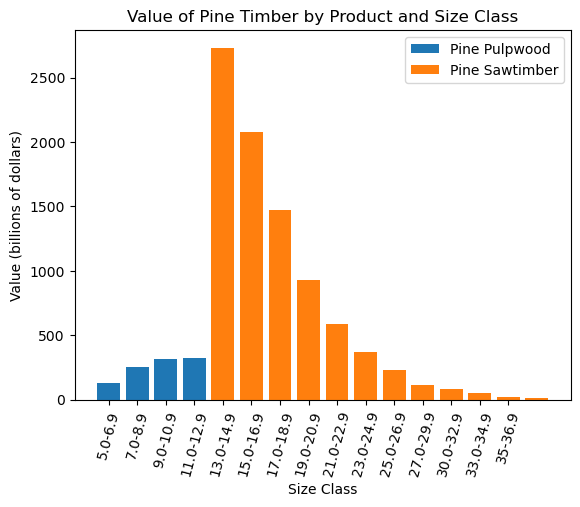

In [153]:
# plot a histogram of the value of timber by priceSpecies and product
import matplotlib.pyplot as plt

# create a figure and axis
fig, ax = plt.subplots()

summaryPine = summarySouth.loc[summarySouth.index.get_level_values('priceSpecies') == 'Pine']

# plot a histogram of the volume of timber by priceSpecies and product
for species in summaryPine.index.get_level_values('priceSpecies').unique():
    for product in summaryPine.index.get_level_values('Product').unique():
        data = summaryPine.loc[(summaryPine.index.get_level_values('priceSpecies') == species) &
                                (summaryPine.index.get_level_values('Product') == product)]
        ax.bar(data.index.get_level_values('size_class_code'), data['value'], label=species + ' ' + product)

# specify the x labels
xlabs = ['5.0-6.9', '7.0-8.9', '9.0-10.9', '11.0-12.9',
          '13.0-14.9', '15.0-16.9', '17.0-18.9', '19.0-20.9',
            '21.0-22.9', '23.0-24.9', '25.0-26.9', '27.0-29.9',
            '30.0-32.9', '33.0-34.9', '35-36.9']

# format the x labels to be more readable
ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)

# space out the x labels
plt.xticks(rotation=75)

# set title and labels
ax.set_title('Value of Pine Timber by Product and Size Class')
ax.set_xlabel('Size Class')
ax.set_ylabel('Value (billions of dollars)')
ax.legend()

# display the plot
plt.show()

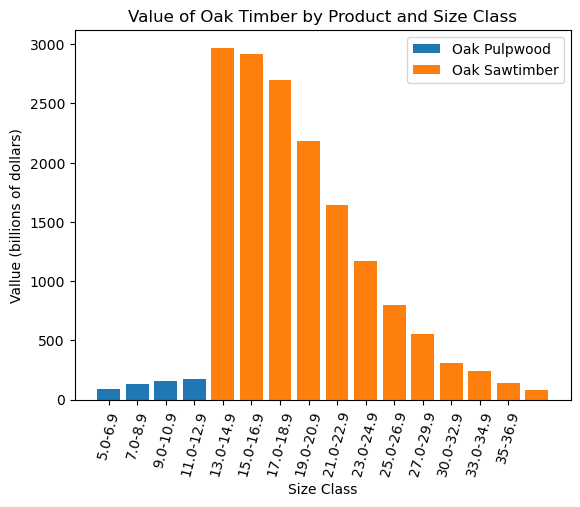

In [154]:
# plot a histogram of the value of timber by priceSpecies and product
import matplotlib.pyplot as plt

# create a figure and axis
fig, ax = plt.subplots()

summaryOak = summarySouth.loc[summarySouth.index.get_level_values('priceSpecies') == 'Oak']

# plot a histogram of the volume of timber by priceSpecies and product
for species in summaryOak.index.get_level_values('priceSpecies').unique():
    for product in summaryOak.index.get_level_values('Product').unique():
        data = summaryOak.loc[(summaryOak.index.get_level_values('priceSpecies') == species) &
                                (summaryOak.index.get_level_values('Product') == product)]
        ax.bar(data.index.get_level_values('size_class_code'), data['value'], label=species + ' ' + product)

# specify the x labels
xlabs = ['5.0-6.9', '7.0-8.9', '9.0-10.9', '11.0-12.9',
          '13.0-14.9', '15.0-16.9', '17.0-18.9', '19.0-20.9',
            '21.0-22.9', '23.0-24.9', '25.0-26.9', '27.0-29.9',
            '30.0-32.9', '33.0-34.9', '35-36.9']

# format the x labels to be more readable
ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)

# space out the x labels
plt.xticks(rotation=75)

# set title and labels
ax.set_title('Value of Oak Timber by Product and Size Class')
ax.set_xlabel('Size Class')
ax.set_ylabel('Vallue (billions of dollars)')
ax.legend()

# display the plot
plt.show()

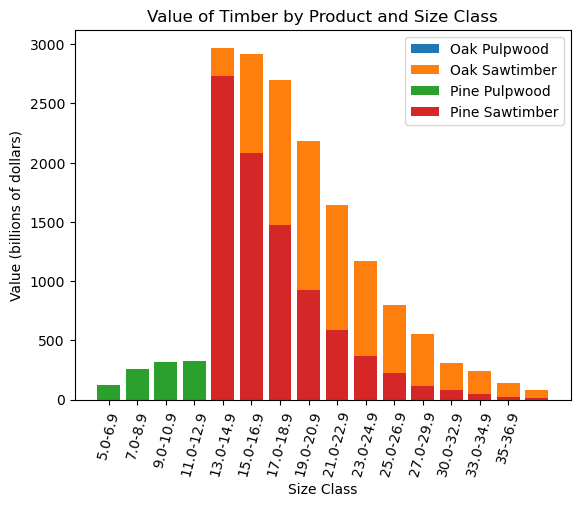

In [155]:
# plot a histogram of the value of timber by priceSpecies and product

# create a figure and axis
fig, ax = plt.subplots()

# plot a histogram of the value of timber by priceSpecies and product

for species in summarySouth.index.get_level_values('priceSpecies').unique():
    for product in summarySouth.index.get_level_values('Product').unique():
        data = summarySouth.loc[(summarySouth.index.get_level_values('priceSpecies') == species) &
                                (summarySouth.index.get_level_values('Product') == product)]
        ax.bar(data.index.get_level_values('size_class_code'), data['value'], label=species + ' ' + product)

# specify the x labels
xlabs = ['5.0-6.9', '7.0-8.9', '9.0-10.9', '11.0-12.9',
          '13.0-14.9', '15.0-16.9', '17.0-18.9', '19.0-20.9',
            '21.0-22.9', '23.0-24.9', '25.0-26.9', '27.0-29.9',
            '30.0-32.9', '33.0-34.9', '35-36.9']

# format the x labels to be more readable
ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)

# space out the x labels
plt.xticks(rotation=75)

# set title and labels
ax.set_title('Value of Timber by Product and Size Class')
ax.set_xlabel('Size Class')
ax.set_ylabel('Value (billions of dollars)')
ax.legend()

# display the plot
plt.show()

### Total Southern Timber Value by State


In [156]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Define pilot states
pilotStates = ['AL', 'AR', 'FL', 'GA', 'LA',
               'MS', 'NC', 'OK', 'SC', 'TN',
               'TX', 'VA']

# Load the shapefile locally
shapefile_path = '/Users/mihiarc/Work/spatial-boundaries/tl_2023_us_state/tl_2023_us_state.shp'
states = gpd.read_file(shapefile_path)

# Filter the states shapefile to only include the pilot states
states = states[states['STUSPS'].isin(pilotStates)]


# Change the CRS to Albers Equal Area
albers_crs = 'EPSG:5070'
states = states.to_crs(albers_crs)


# prepare the pine data for mapping
# group by stateAbbr and sum the value
timberValue = tableSouth.groupby('stateAbbr')['value'].sum().reset_index()

# divide the value by 1 billion
timberValue['value'] = timberValue['value'] / 1000000000

# sort by value
timberValue = timberValue.sort_values('value', ascending=False)

# print the timberValue table; round to 2 decimal places
print(f"Total Southern Timber Value by State (in billions):\n{timberValue.round(2)}")


Total Southern Timber Value by State (in billions):
  stateAbbr    value
9        VA  4707.60
0        AL  3998.91
3        GA  3513.71
6        NC  3228.63
8        TN  2623.01
7        SC  2407.86
1        AR  2129.87
5        MS  1617.28
4        LA  1106.10
2        FL   612.73


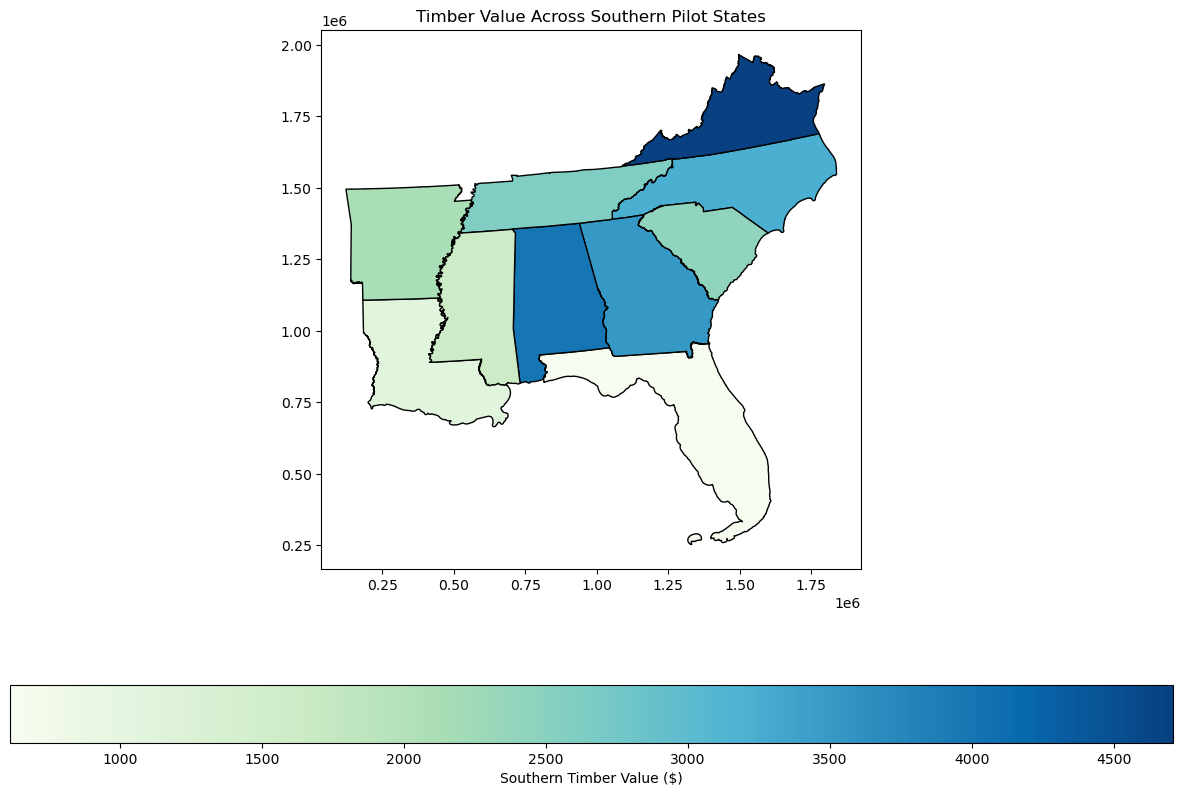

In [157]:
# Merge the GeoDataFrame with the pine timber volume DataFrame
# rename stateAbbr to STUSPS to match the states GeoDataFrame
timberValue.rename(columns={'stateAbbr': 'STUSPS'}, inplace=True)
states = states.merge(timberValue, on='STUSPS')


# Plot the choropleth map
fig, ax = plt.subplots(figsize=(15, 10))
states.plot(column='value', ax=ax, legend=True,
            legend_kwds={'label': "Southern Timber Value ($)",
                         'orientation': "horizontal"},
            cmap='GnBu', edgecolor='black')

# # Set plot title
plt.title('Timber Value Across Southern Pilot States')

# # Show the plot
plt.show()

### (Incomplete) TimberMart North Stumpage Prices

In [158]:
# read in northern price data from excel file
import openpyxl

pricesNorth = pd.read_excel('../data/Timber Prices/TMN_Price_Series_September2023.xlsx')

# drop all rows where Region has exactly 2 characters
pricesNorth = pricesNorth[pricesNorth['Region'].str.len() != 2]

# filter for Market = 'Stumpage'
pricesNorth = pricesNorth[pricesNorth['Market'] == 'Stumpage']

# convert 'Period End Date' to datetime
pricesNorth['Period End Date'] = pd.to_datetime(pricesNorth['Period End Date'],
                                                errors='coerce')

# create a year variable from column "Period End Date"
pricesNorth['year'] = pricesNorth['Period End Date'].dt.year

# split the Region column into two columns on '-'
pricesNorth[['state_abbr', 'priceRegion']] = pricesNorth['Region'].str.split('-', n=1, expand=True)
pricesNorth['priceRegion'] = pricesNorth['priceRegion'].str.zfill(2)

# add a column for the state fips code
# first, create a dictionary of state abbreviations and fips codes for MN, WI, MI
state_fips = {'MN': '27', 'WI': '55', 'MI': '26'}
pricesNorth['statecd'] = pricesNorth['state_abbr'].map(state_fips)
pricesNorth['priceRegion'] = pricesNorth['statecd'] + pricesNorth['priceRegion']

# select only the columns we need
# year, priceRegion, Species, Product, $ Per Unit, Units
pricesNorth = pricesNorth[['year', 'priceRegion', 'Species',
                            'Product', '$ Per Unit', 'Units']]

# drop if $ Per Unit is NaN or year is NaN
pricesNorth = pricesNorth.dropna(subset=['$ Per Unit', 'year'])

# if the Units column is 'Cords', convert $ Per Unit to $ per cord
# if the Units column is 'MBF', convert $ Per Unit to $ per MBF
# conversion factors are 1 cord = 128 cubic feet and 1 MBF = 1000 board feet
# 12 board feet = 1 cubic foot
pricesNorth['$ Per Unit'] = pricesNorth['$ Per Unit'].astype(float)
pricesNorth['cuftPrice'] = pricesNorth['$ Per Unit']
pricesNorth.loc[pricesNorth['Units'] == 'cord', 'cuftPrice'] = pricesNorth['$ Per Unit'] / 128
pricesNorth.loc[pricesNorth['Units'] == 'mbf', 'cuftPrice'] = pricesNorth['$ Per Unit'] / 12

# drop the $ Per Unit and Units columns
pricesNorth = pricesNorth.drop(columns=['$ Per Unit', 'Units'])

# rename variables
pricesNorth.rename(columns={'Species': 'priceSpecies'}, inplace=True)

# aggregate over years
pricesNorth = pricesNorth.groupby(
    ['priceRegion', 'priceSpecies', 'Product']).mean().reset_index()

# pivot the table so that each row is a unique year, 
# priceRegion, priceSpecies
# and the columns are the products
pricesNorth = pricesNorth.pivot(
    index=['priceRegion', 'priceSpecies'],
    columns='Product',
    values='cuftPrice').reset_index()

# some prices are not reported for all products
# fill missing values with 0
pricesNorth = pricesNorth.fillna(0)

pricesNorth.groupby('priceSpecies').describe()

Product            Pulpwood                                                    \
                      count      mean       std       min       25%       50%   
priceSpecies                                                                    
Ash                     8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Aspen                   8.0  0.233790  0.038959  0.166281  0.212307  0.234573   
Basswood                8.0  0.080035  0.029286  0.028779  0.065595  0.082433   
Beech                   8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Birch                   1.0  0.000000       NaN  0.000000  0.000000  0.000000   
Black Ash               2.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Black Cherry            6.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Black Walnut            1.0  0.000000       NaN  0.000000  0.000000  0.000000   
Elm                     2.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Hard Maple              8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Hemlock                 2.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Hickory                 2.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Jack Pine               8.0  0.297293  0.078331  0.183333  0.242509  0.288127   
Maple Unspecified       3.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Mixed Hdwd              8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Mixed Sftwd             6.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Oak                     8.0  0.171348  0.026688  0.136951  0.158687  0.167964   
Oak Unspecified         7.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Other Hardwood          8.0  0.144099  0.042189  0.069880  0.125598  0.153469   
Other Hdwd              8.0  0.194219  0.064562  0.102750  0.143883  0.219920   
Other Sfwd              8.0  0.218593  0.084367  0.065399  0.187677  0.236286   
Other Softwood          8.0  0.137004  0.029011  0.089059  0.118867  0.138305   
Pine                    1.0  0.000000       NaN  0.000000  0.000000  0.000000   
Pine Unspecified        4.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Red Oak                 8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Red Pine                8.0  0.410263  0.102884  0.267858  0.327066  0.433153   
Sawtimber ($/mbf)       7.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Scrub Oak               3.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Soft Maple              8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Spruce                  8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Spruce Unspecified      3.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Spruce/Fir              8.0  0.187332  0.037939  0.114330  0.176652  0.185610   
White Ash               6.0  0.000000  0.000000  0.000000  0.000000  0.000000   
White Birch             8.0  0.159792  0.042154  0.115199  0.125602  0.146125   
White Oak               8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
White Pine              8.0  0.000000  0.000000  0.000000  0.000000  0.000000   
White Spruce            5.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Yellow Birch            8.0  0.000000  0.000000  0.000000  0.000000  0.000000   

Product                                Sawtimber                         \
                         75%       max     count        mean        std   
priceSpecies                                                              
Ash                 0.000000  0.000000       8.0    9.667374   2.924213   
Aspen               0.264151  0.278622       8.0    7.090165   2.480493   
Basswood            0.090220  0.129494       8.0   11.178991   2.735776   
Beech               0.000000  0.000000       8.0    7.587131   2.093239   
Birch               0.000000  0.000000       1.0   14.583333        NaN   
Black Ash           0.000000  0.000000       2.0   11.041667   5.597929   
Bla

Split pulpwood and sawtimber into separate dataframes

In [159]:
pricesPulpNorth = pricesNorth.drop(columns = 'Sawtimber')
pricesPulpNorth = pricesPulpNorth[pricesPulpNorth['Pulpwood'] != 0]
pricesPulpNorth.groupby('priceSpecies').describe()

Product        Pulpwood                                                    \
                  count      mean       std       min       25%       50%   
priceSpecies                                                                
Aspen               8.0  0.233790  0.038959  0.166281  0.212307  0.234573   
Basswood            8.0  0.080035  0.029286  0.028779  0.065595  0.082433   
Jack Pine           8.0  0.297293  0.078331  0.183333  0.242509  0.288127   
Oak                 8.0  0.171348  0.026688  0.136951  0.158687  0.167964   
Other Hardwood      8.0  0.144099  0.042189  0.069880  0.125598  0.153469   
Other Hdwd          8.0  0.194219  0.064562  0.102750  0.143883  0.219920   
Other Sfwd          8.0  0.218593  0.084367  0.065399  0.187677  0.236286   
Other Softwood      8.0  0.137004  0.029011  0.089059  0.118867  0.138305   
Red Pine            8.0  0.410263  0.102884  0.267858  0.327066  0.433153   
Spruce/Fir          8.0  0.187332  0.037939  0.114330  0.176652  0.185610   
White Birch         8.0  0.159792  0.042154  0.115199  0.125602  0.146125   

Product                             
                     75%       max  
priceSpecies                        
Aspen           0.264151  0.278622  
Basswood        0.090220  0.129494  
Jack Pine       0.352947  0.405556  
Oak             0.179326  0.226764  
Other Hardwood  0.167350  0.193819  
Other Hdwd      0.244826  0.256984  
Other Sfwd      0.262180  0.339243  
Other Softwood  0.159814  0.169394  
Red Pine        0.468439  0.548446  
Spruce/Fir      0.203101  0.246292  
White Birch     0.194522  0.222912

In [160]:
pricesSawNorth = pricesNorth.drop(columns = 'Pulpwood')
pricesSawNorth = pricesSawNorth[pricesSawNorth['Sawtimber'] != 0]
pricesSawNorth.groupby('priceSpecies').describe()

Product            Sawtimber                                                 \
                       count        mean        std         min         25%   
priceSpecies                                                                  
Ash                      8.0    9.667374   2.924213    5.465222    7.911426   
Aspen                    8.0    7.090165   2.480493    3.759807    5.754199   
Basswood                 8.0   11.178991   2.735776    6.781604    9.016016   
Beech                    8.0    7.587131   2.093239    5.989583    6.522374   
Birch                    1.0   14.583333        NaN   14.583333   14.583333   
Black Ash                2.0   11.041667   5.597929    7.083333    9.062500   
Black Cherry             6.0   19.182346   6.372149   11.734611   14.356585   
Black Walnut             1.0  174.229645        NaN  174.229645  174.229645   
Elm                      2.0    5.477033   2.654668    3.599900    4.538467   
Hard Maple               8.0   35.526016  14.089273   11.016377   29.009980   
Hemlock                  2.0   14.445833  12.769170    5.416667    9.931250   
Hickory                  2.0   18.831898  14.026314    8.913796   13.872847   
Jack Pine                8.0    6.756899   1.310611    4.166667    6.365278   
Maple Unspecified        3.0   12.500595   9.265978    7.130952    7.150893   
Mixed Hdwd               8.0   13.025712   6.660266    4.096625    8.194583   
Mixed Sftwd              6.0   10.904099  10.000926    1.414931    4.696626   
Oak                      3.0    8.126111   5.525415    2.500000    5.416667   
Oak Unspecified          7.0   15.607155   6.459376    7.785729   11.644097   
Other Hardwood           8.0   11.941366   2.993292    6.463148    9.806523   
Other Softwood           8.0    6.212827   1.482716    4.223080    5.130573   
Pine                     1.0    8.610000        NaN    8.610000    8.610000   
Pine Unspecified         4.0   10.106973   2.961050    6.210069    8.926615   
Red Oak                  8.0   26.019556   5.902071   12.411111   25.435654   
Red Pine                 8.0   11.814165   3.369948    6.810064    9.868830   
Sawtimber ($/mbf)        7.0    2.617478   1.021774    1.352857    1.950588   
Scrub Oak                3.0   12.479167   7.624061    7.437500    8.093750   
Soft Maple               8.0   13.992388   4.067800    6.492083   11.914322   
Spruce                   8.0    5.604294   1.337401    2.771250    5.344580   
Spruce Unspecified       3.0    5.651996   2.548712    3.229109    4.322888   
White Ash                6.0   14.647847   5.892741    7.500000   10.790208   
White Birch              8.0   10.777441   3.967120    5.205614    7.936626   
White Oak                8.0   13.082577   4.716771    7.715930    9.794122   
White Pine               8.0    8.761967   2.026108    4.304359    8.220109   
White Spruce             5.0    5.492785   3.388982    1.361111    3.621212   
Yellow Birch             8.0   15.721761   4.123222    7.434524   14.370936   

Product                                                 
                           50%         75%         max  
priceSpecies                                            
Ash                   9.276906   12.112972   13.421702  
Aspen                 6.076828    8.808975   11.167589  
Basswood             12.406528   13.266694   13.843603  
Beech                 6.973366    7.388942   12.500000  
Birch                14.583333   14.583333   14.583333  
Black Ash            11.041667   13.020833   15.000000  
Black Cherry         20.184821   21.161942   29.088333  
Black Walnut        174.229645  174.229645  174.229645  
Elm                   5.477033    6.415600    7.354167  
Hard Maple           35.652637   44.346964   55.098868  
Hemlock              14.445833   18.960417   23.475000  
Hickory              18.831898   23.790949   28.750000  
Jack Pine             6.807280    7.465313    8.680588  
Maple Unspecified     7.170833   15.185417   23.200000  
Mixed Hdwd           14.2060

Combine north and south prices

In [161]:
# # concatenate pricesNorth and pricesSouth
# prices = pd.concat([pricesNorth, pricesSouth])

# # filter prices for only the years 2015-2020
# #prices = prices[(prices['year'] >= 2015) & (prices['year'] <= 2020)]

# # aggreate prices by region, species, and product
# prices = prices.groupby(['priceRegion',
#                          'priceSpecies', 'Product'])['cuftPrice'].mean().reset_index()

# # pivot the table so that each row is identified by priceRegion and priceSpecies
# # and each column is a unique product price
# prices = prices.pivot(index=['priceRegion', 'priceSpecies'],
#                         columns='Product', values='cuftPrice').reset_index()

# # some species do not have prices for all products; set these to 0
# prices = prices.fillna(0)

# prices.groupby('priceSpecies').describe()

## Match Species in pricesNorth with spgrpnm and spclass in biomass

Species list in the TimberMart North data

In [162]:
# print unique values in the Species column
print(pricesNorth['priceSpecies'].unique())

['Ash' 'Aspen' 'Basswood' 'Beech' 'Black Cherry' 'Elm' 'Hard Maple'
 'Jack Pine' 'Mixed Hdwd' 'Mixed Sftwd' 'Oak' 'Oak Unspecified'
 'Other Hardwood' 'Other Hdwd' 'Other Sfwd' 'Other Softwood'
 'Pine Unspecified' 'Red Oak' 'Red Pine' 'Sawtimber ($/mbf)' 'Soft Maple'
 'Spruce' 'Spruce Unspecified' 'Spruce/Fir' 'White Ash' 'White Birch'
 'White Oak' 'White Pine' 'White Spruce' 'Yellow Birch' 'Black Walnut'
 'Hickory' 'Maple Unspecified' 'Scrub Oak' 'Pine' 'Black Ash' 'Hemlock'
 'Birch']


Species groups in the FIA biomass data

In [150]:
# filter for state of Michigan, Wisconsin, and Minnesota
# print unique values in the spgrpnm column
speciesNorth = biomass[biomass['state'].isin(['Michigan', 'Wisconsin', 'Minnesota'])]
speciesNorth = speciesNorth[['spgrpnm']].sort_values('spgrpnm')
print(speciesNorth['spgrpnm'].unique())


['Ash' 'Basswood' 'Beech' 'Black walnut' 'Cottonwood and aspen (East)'
 'Eastern hemlock' 'Eastern white and red pines' 'Hard maple' 'Hickory'
 'Jack pine' 'Other eastern hard hardwoods' 'Other eastern soft hardwoods'
 'Other eastern softwoods' 'Other red oaks' 'Other yellow pines'
 'Select red oaks' 'Select white oaks' 'Soft maple'
 'Spruce and balsam fir' 'Tupelo and blackgum' 'Yellow birch']


* Rule: Prices should be interpolated to match biomass
* Every observation in the FIA data should be assigned a price.

In [171]:
# create a dictionary to assign a 'Species' or group of 'Species' from
# the price data to a 'spgrpnm' from the biomass data. The length of the
# dictionary should be the number of unique values in the 'spgrpnm' column
# of the biomass data.

# species list from price data
# ['Ash''Black Ash'  'White Ash' 
#  'Aspen' 
# 'Basswood'
#  'Beech'
#  'Oak''Red Oak' 'Scrub Oak' 'Oak Unspecified'
#  'Hard Maple''Soft Maple''Maple Unspecified' 
#  'Spruce' 'Spruce/Fir' 'White Birch' 'White Oak' 
# 'Jack Pine''White Pine''Red Pine''Pine''Pine Unspecified'
#  'Yellow Birch' 
# 'Other Hardwood' 'Other Softwood' 
# 'Mixed Hdwd' 'Other Hdwd''Mixed Sftwd'  'Other Sfwd' 
# 'Black Cherry'
#  'Black Walnut' 
# 'Elm' 
# 'Hickory'  
# 'White Spruce''Spruce Unspecified'
#  'Hemlock'
#  'Birch' 

# species list from biomass data
# ['Ash' 
# 'Basswood' 
# 'Beech'
#  'Black walnut' 
# 'Cottonwood and aspen (East)'
#  'Eastern hemlock'
#  'Eastern white and red pines' 
# 'Hard maple' 
# 'Hickory'
#  'Jack pine' 
# 'Other eastern hard hardwoods'
#  'Other eastern soft hardwoods'
#  'Other eastern softwoods'
#  'Other red oaks' 
# 'Other yellow pines'
#  'Select red oaks' 
# 'Select white oaks' 
# 'Soft maple'
#  'Spruce and balsam fir' 
# 'Tupelo and blackgum' 
# 'Yellow birch']

# format is {'priceSpecies': 'fiaSpecies'}

# trying the reverse of the above
speciesCrosswalkNorth = {
    'Ash': 'Ash',
    'Basswood': 'Basswood',
    'Beech': 'Beech',
    'Black Walnut': 'Black walnut',
    'Aspen': 'Cottonwood and aspen (East)',
    'Hemlock': 'Eastern hemlock',
    'Red Pine': 'Eastern white and red pines',
    'White Pine': 'Eastern white and red pines',
    'Hard Maple': 'Hard maple',
    'Hickory': 'Hickory',
    'Jack Pine': 'Jack pine',
    'Pine': 'Loblolly and shortleaf pines',
    'Unspecified Pine': 'Loblolly and shortleaf pines',
    'Other Hardwood': 'Other eastern hard hardwoods',
    'Other Hdwd': 'Other eastern hard hardwoods',
    'Other Softwood': 'Other eastern soft hardwoods',
    'Other Sfwd': 'Other eastern soft hardwoods',
    'Red Oak': 'Other red oaks',
    'White Oak': 'Select white oaks',
    'Soft Maple': 'Soft maple',
    'White Spruce': 'Spruce and balsam fir',
    'Spruce': 'Spruce and balsam fir',
    'Spruce/Fir': 'Spruce and balsam fir',
    'Birch': 'Yellow birch',
    'Black Cherry': '',
    'Elm': '',
    'Mixed Hdwd': '',
    'Mixed Sftwd': '',
    'Oak': '',
    'Oak Unspecified': '',
    'Pine Unspecified': '',
    'Spruce Unspecified': '',
    'White Ash': 'Ash',
    'White Birch': '',
    'Yellow Birch': '',
    'Maple Unspecified': '',
    'Scrub Oak': '',
    'Black Ash': 'Ash'
}


# using the crosswalk, rename the 'Species' column in the price data
# to 'priceSpecies'
pricesNorth['fiaSpecies'] = pricesNorth['priceSpecies'].map(speciesCrosswalkNorth)

# print the priceSpecies where fiaSpecies is null
print(pricesNorth[pricesNorth['fiaSpecies'].isnull()]['priceSpecies'].unique())

# use the crosswalk to create a new column in the biomass data called 'priceSpecies'
# apply this to only the northern states of Michigan, Wisconsin, and Minnesota

#biomass.loc[biomass['state'].isin(['Michigan', 'Wisconsin', 'Minnesota']),
                #    'priceSpecies'] = biomass['spgrpnm'].map(speciesCrosswalkNorth)


['Black Cherry' 'Elm' 'Mixed Hdwd' 'Mixed Sftwd' 'Oak' 'Oak Unspecified'
 'Pine Unspecified' 'Sawtimber ($/mbf)' 'Spruce Unspecified' 'White Ash'
 'White Birch' 'Yellow Birch' 'Maple Unspecified' 'Scrub Oak' 'Black Ash']


In [152]:
# Repeat above steps for the southern states of Alabama, Arkansas,
#  Florida, Georgia, Kentucky, Louisiana, Mississippi, North Carolina,
#  Oklahoma, South Carolina, Tennessee, Texas, and Virginia

speciesSouth = biomass[biomass['state'].isin(['Alabama', 'Arkansas', 'Florida',
                                                'Georgia', 'Kentucky', 'Louisiana',
                                                'Mississippi', 'North Carolina',
                                                'Oklahoma', 'South Carolina',
                                                'Tennessee', 'Texas', 'Virginia'])]
speciesSouth = speciesSouth[['spclass']].sort_values('spclass')
print(speciesSouth['spclass'].unique())

['Hardwood' 'Softwood']


In [155]:
# create dictionary for spclass to priceSpecies for the southern states

speciesCrosswalkSouth = {
 'Softwood': 'Pine',
 'Hardwood': 'Oak'
}

# use the crosswalk to create a new column in the biomass data called 'priceSpecies'
# apply this to only the southern states of Alabama, Arkansas, Florida,
# Georgia, Kentucky,Louisiana, Mississippi, North Carolina,
# Oklahoma, South Carolina, Tennessee, Texas, and Virginia

biomass.loc[biomass['state'].isin(['Alabama', 'Arkansas', 'Florida',
                                    'Georgia', 'Kentucky', 'Louisiana',
                                    'Mississippi', 'North Carolina',
                                    'Oklahoma', 'South Carolina',
                                    'Tennessee', 'Texas', 'Virginia']),
            'priceSpecies'] = biomass['spclass'].map(speciesCrosswalkSouth)


Now we need to differentiate which products (and prices) go with which size classes.

- Sawtimber price applies to sizes 13 inches to 40+ inches
- Pulpwood price applies to sizes 5 inches to 12.9 inches
- under 5 inches are given a price less than pulpwood (pre-merchantable)

In [ ]:
# in biomass, create a new column for priceRegion that is the two digit state
# fips code followed by the two digit price region code
biomass['priceRegion'] = biomass['fips'].str[:2] + biomass['priceRegion']

# print unique spclass from biomass
print(biomass['priceSpecies'].unique())


# merge biomass with prices on priceRegion and priceSpecies; call it assetTable
# assetTable = pd.merge(
#     biomass,
#     prices,
#     on=['priceRegion', 'priceSpecies'],
#     how='left')
